# Chapter 3. Unsupervised Learning methods.
# Part 2. Data Preprocessing: PCA, NMF, t-SNE

PCA - (principal component analysis) dimensionality reduction and feature extraction via generating new feature space

NMF - (non-negative matrix factorization) feature extraction

t-SNE - (t-distributed stochastic neighbor embedding) visualization with scatter plots

## - PCA

PCA principle is about dataset rotation so samples wouldn't correlate

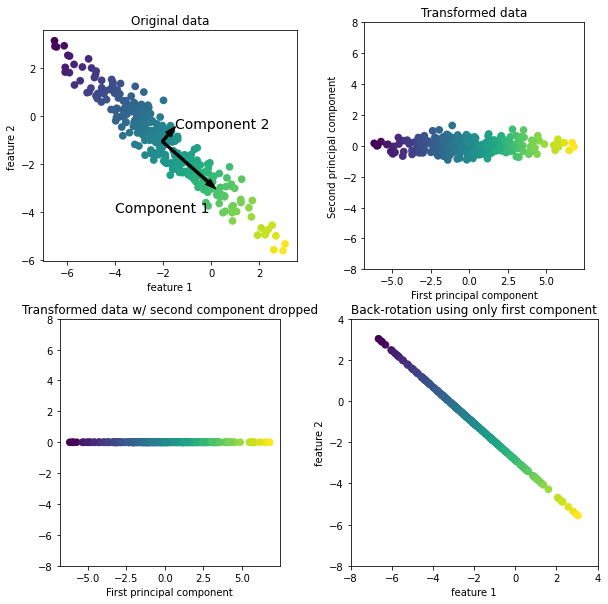

In [3]:
import mglearn
mglearn.plots.plot_pca_illustration()

^ Component is an axis that includes the most of information in dataset (axis of highest data dispersion) picked up iteratively

## PCA for data visualiztion

To get better clue of dataset without PCA it's useful to look at class comparison by a feature:

Text(0, 0.5, 'frequency')

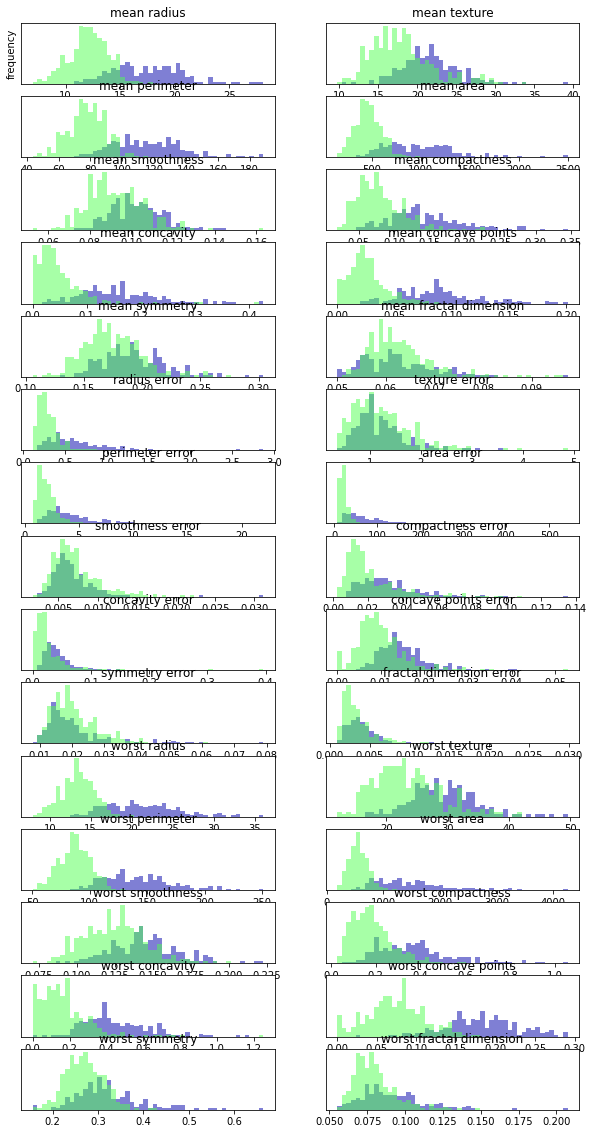

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_breast_cancer
cancer = load_breast_cancer()

fig, axes = plt.subplots(15,2, figsize=(10,20))
malignant = cancer.data[cancer.target == 0]
benign = cancer.data[cancer.target == 1]
ax = axes.ravel()

for i in range(30):
    _, bins = np.histogram(cancer.data[:, i], bins=50)
    ax[i].hist(malignant[:, i], bins=bins, color=mglearn.cm3(0), alpha=0.5)
    ax[i].hist(benign[:, i], bins=bins, color=mglearn.cm3(2), alpha=0.5)
    ax[i].set_title(cancer.feature_names[i])
    ax[i].set_yticks(())
ax[0].set_xlabel('feature value')
ax[0].set_ylabel('frequency')

^ 'worst cancave points' is pretty useful and 'smoothness error' is not. But this diagram doesn't account for the dependensies between features.

To get better clue of dataset with feature dependensies and correlations it's useful to find principal components via PCA (to prescaled data):

Source dataset shape: (569, 30)
New dataset shape: (569, 2)


Text(0, 0.5, 'Second principal component')

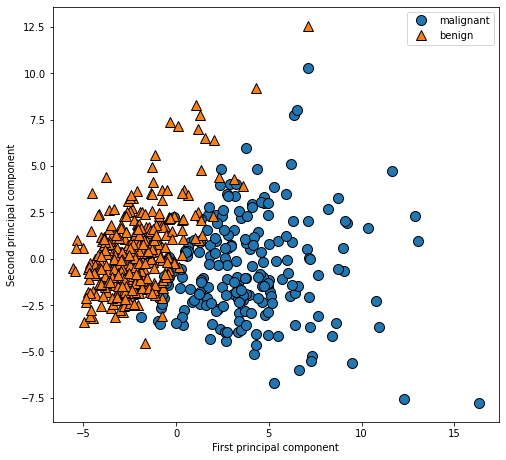

In [5]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

#-----prescaling data and PCA implementation
#--initialization, building and applying scaler
scaler = StandardScaler()
scaler.fit(cancer.data)
X_scaled = scaler.transform(cancer.data)

#--initialization, building and applying PCA.
#dimensionality reduction is made by giving an argument to...
#...a PCA object as a count of needed components
pca = PCA(n_components=2)
#'.fit' finds principal components
pca.fit(X_scaled)
#'.transform' rotates and moves data
X_pca = pca.transform(X_scaled)

#--datasets comparison
print('Source dataset shape: {}'.format(str(X_scaled.shape)))
print('New dataset shape: {}'.format(str(X_pca.shape)))

#-----visualizing PCA dataset
plt.figure(figsize=(8, 8))
mglearn.discrete_scatter(X_pca[:, 0], X_pca[:, 1], cancer.target)
plt.legend(cancer.target_names, loc='best')
plt.gca().set_aspect('equal')
plt.xlabel('First principal component')
plt.ylabel('Second principal component')

Principal components are stored in 'components_' and columns are the source features:

Principal components data shape: (2, 30)
Principal components:
 [[ 0.21890244  0.10372458  0.22753729  0.22099499  0.14258969  0.23928535
   0.25840048  0.26085376  0.13816696  0.06436335  0.20597878  0.01742803
   0.21132592  0.20286964  0.01453145  0.17039345  0.15358979  0.1834174
   0.04249842  0.10256832  0.22799663  0.10446933  0.23663968  0.22487053
   0.12795256  0.21009588  0.22876753  0.25088597  0.12290456  0.13178394]
 [-0.23385713 -0.05970609 -0.21518136 -0.23107671  0.18611302  0.15189161
   0.06016536 -0.0347675   0.19034877  0.36657547 -0.10555215  0.08997968
  -0.08945723 -0.15229263  0.20443045  0.2327159   0.19720728  0.13032156
   0.183848    0.28009203 -0.21986638 -0.0454673  -0.19987843 -0.21935186
   0.17230435  0.14359317  0.09796411 -0.00825724  0.14188335  0.27533947]]


Text(0, 0.5, 'Principal components')

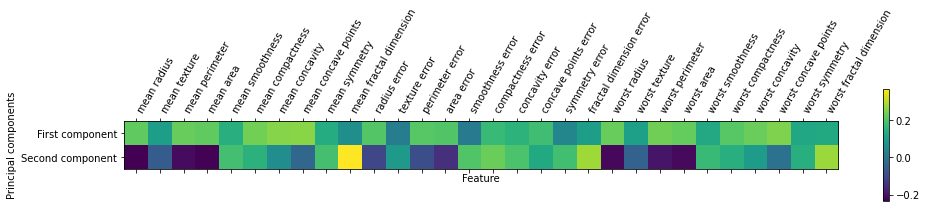

In [6]:
print('Principal components data shape: {}'.format(pca.components_.shape))
print('Principal components:\n {}'.format(pca.components_))

#PCA components visualization via heatmap
plt.matshow(pca.components_, cmap='viridis')
plt.yticks([0,1], ['First component', 'Second component'])
plt.colorbar()
plt.xticks(range(len(cancer.feature_names)), cancer.feature_names, rotation=60, ha='left')
plt.xlabel('Feature')
plt.ylabel('Principal components')

^ color intensivity tells about correlation strength between all the rest features for component

## PCA for feature extraction (eigenfaces)

Applying PCA to image dataset made of pixels generates a new feature space instead of the original space of every pixel as a feature itself.

New generated feature space could be more well interpreted, more inforamtive and more compact. Components as a features are not pixels anymore but images that represent some characteristics of train samples. The less the count of components, the less is model accuracy to reconstruct image.

PCA components allows to represent samples as weighted sum of components and their coefficients.

#### Dataset loading and preparing:

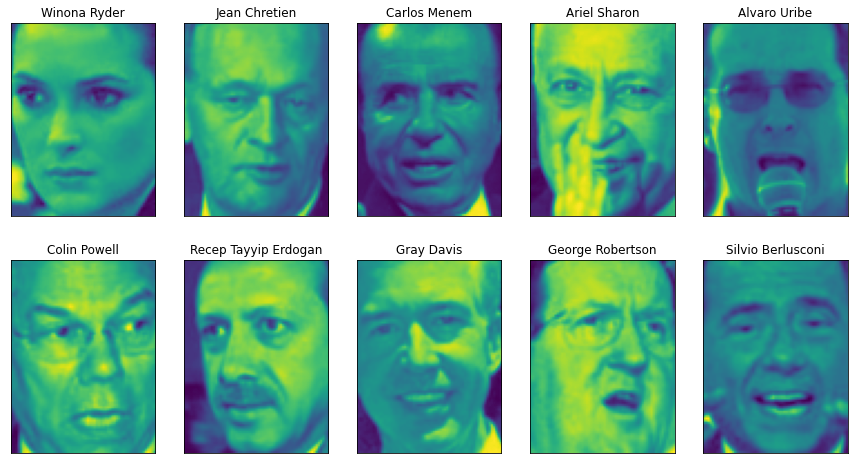

In [7]:
from sklearn.datasets import fetch_lfw_people

people = fetch_lfw_people(min_faces_per_person=20, resize=0.7)
image_shape = people.images[0].shape

fix, axes = plt.subplots(2, 5, figsize=(15, 8), subplot_kw={'xticks': (), 'yticks': ()})

for target, image, ax in zip(people.target, people.images, axes.ravel()):
    ax.imshow(image)
    ax.set_title(people.target_names[target])

^ Gain data is asymmetrical (some of people got overwhelming count of images). So dataset need to be fixed by taking only 50 images as maximum for a person.

Making dataset symmetrical:

In [8]:
mask = np.zeros(people.target.shape, dtype=np.bool)
for target in np.unique(people.target):
    mask[np.where(people.target == target)[0][:50]] = 1
    
X_people = people.data[mask]
y_people = people.target[mask]

<ipython-input-8-b940f3f86508>:1: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros(people.target.shape, dtype=np.bool)


Changing diapason of brightness from 0 t0 255 to 0 to 1:

In [9]:
X_people = X_people / 255

#### PCA implementation and applying:

In [10]:
from sklearn.model_selection import train_test_split

#-----dataset loading and splitting
X_train, X_test, y_train, y_test = train_test_split(X_people, y_people, stratify=y_people, random_state=0)

#-----pca initialization and building
#'whiten' is a param to scale generated components...
#...as like as StandardScaler do.
pca = PCA(n_components=100, whiten=True, random_state=0).fit(X_train)
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)

print('Original dataset: {}'.format(X_train.shape))
print('PCA dataset: {}'.format(X_train_pca.shape))

Original dataset: (1547, 5655)
PCA dataset: (1547, 100)


Applying original dataset and PCA dataset to compare results:

In [11]:
from sklearn.neighbors import KNeighborsClassifier

knn1 = KNeighborsClassifier(n_neighbors=1).fit(X_train, y_train)
knn2 = KNeighborsClassifier(n_neighbors=1).fit(X_train_pca, y_train)

print('Original dataset accuracy: {}'.format(knn1.score(X_test, y_test)))
print('PCA dataset accuracy: {}'.format(knn2.score(X_test_pca, y_test)))

Original dataset accuracy: 0.23449612403100775
PCA dataset accuracy: 0.3062015503875969


^ Accuracy with PCA dataset increased

#### Components render (first of them):

Shape of pca.components_: (100, 5655)


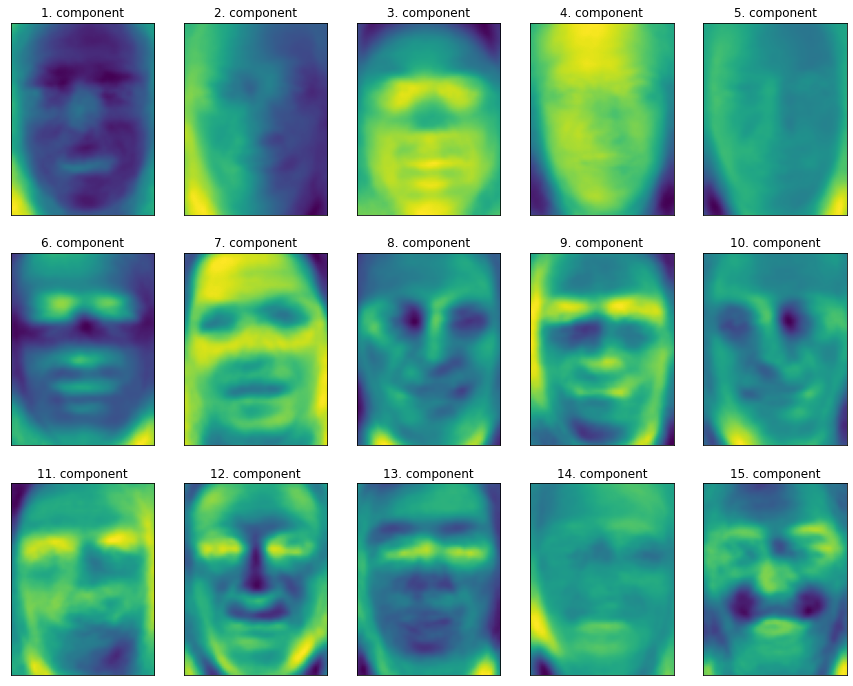

In [12]:
print('Shape of pca.components_: {}'.format(pca.components_.shape))
fix, axes = plt.subplots(3,5, figsize=(15,12), subplot_kw={'xticks': (), 'yticks': ()})

for i, (component, ax) in enumerate(zip(pca.components_, axes.ravel())):
    ax.imshow(component.reshape(image_shape), cmap='viridis')
    ax.set_title('{}. component'.format((i+1)))

## - NMF

NMF has the same appointment as PCA but only for non-negative data. NMF generates non-negative components.

As well as PCA, NMF allows to represent data as weighted sum (but generated components will be non-negative i.e. found components are the constituents of data)

NMF tries to build its components as vector basis. Therefore if count of components are equal to original feature count then components forms an accurate basis for samples

NMF components as basis:

/home/akado/.local/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:312: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(("The 'init' value, when 'init=None' and "
/home/akado/.local/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1090: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"
/home/akado/.local/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:312: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(("The 'init' value, when 'init=None' and "
/home/akado/.local/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1090: ConvergenceWarning: Maximum 

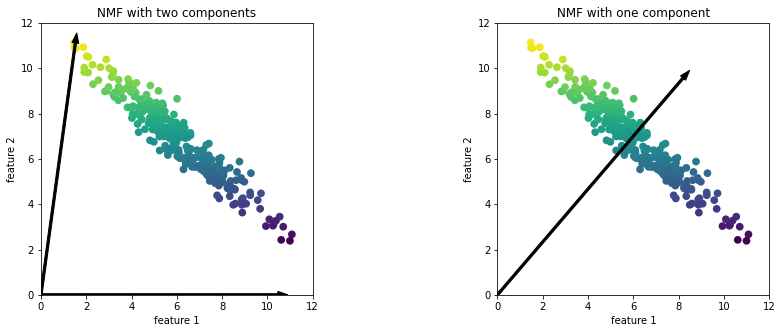

In [13]:
import mglearn.plots
mglearn.plots.plot_nmf_illustration()

## NMF for feature extraction

/home/akado/.local/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:312: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(("The 'init' value, when 'init=None' and "
/home/akado/.local/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1090: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


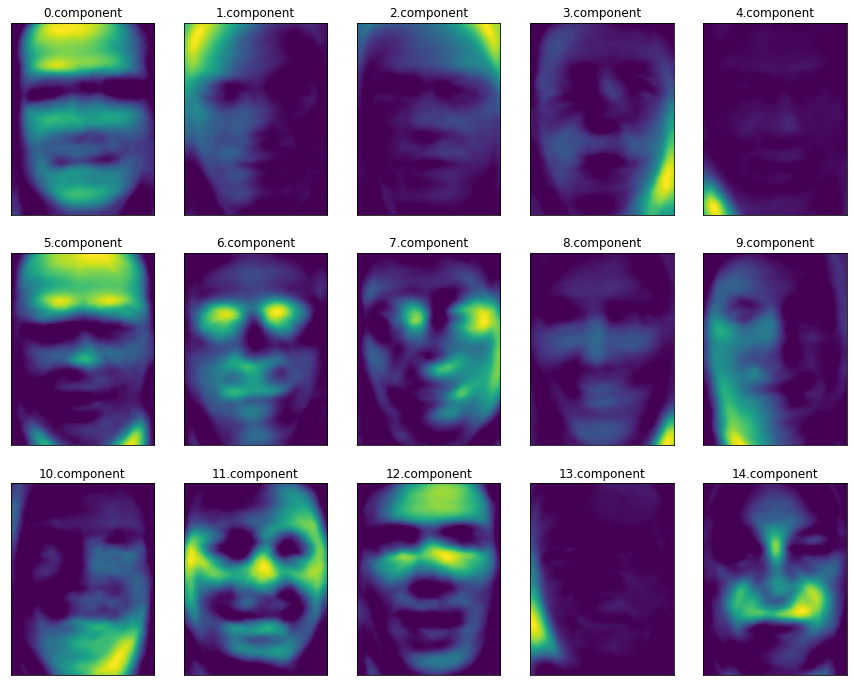

In [16]:
from sklearn.decomposition import NMF

#initialization, building and applying nmf
nmf = NMF(n_components=15, random_state=0).fit(X_train)
X_train_nmf = nmf.transform(X_train)
X_test_nmf = nmf.transform(X_test)

#generated components visualization
fix, axes = plt.subplots(3,5, figsize=(15,12), subplot_kw={'xticks': (), 'yticks': ()})
for i, (component, ax) in enumerate(zip(nmf.components_, axes.ravel())):
    ax.imshow(component.reshape(image_shape))
    ax.set_title('{}.component'.format(i))

^ Gain components represents some aspects of images.

The 11th component represents faces turned left:

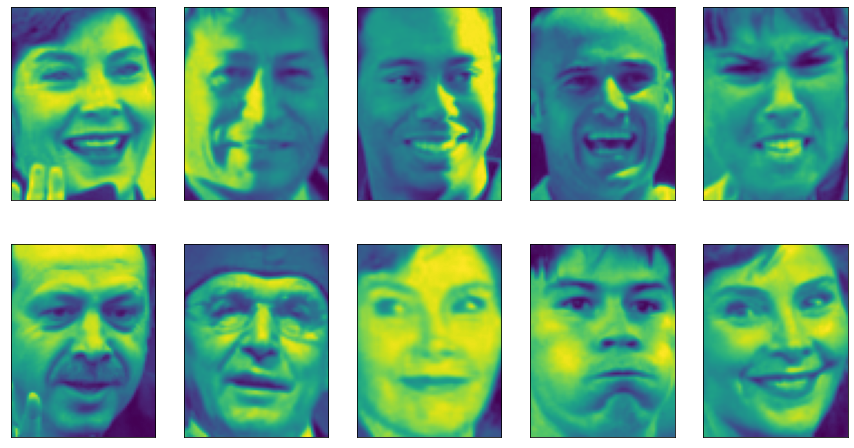

In [17]:
compn = 11
#sorting for 11th component and outputting first 10 images
inds = np.argsort(X_train_nmf[:, compn])[::-1]
#images visualization
fig, axes = plt.subplots(2,5, figsize=(15,8), subplot_kw={'xticks': (), 'yticks': ()})
for i, (ind, ax) in enumerate(zip(inds, axes.ravel())):
    ax.imshow(X_train[ind].reshape(image_shape))

## NMF for pattern extraction

Considering the NMF ability to find constituents of data, this algorithm is also useful to find patterns. For example - decomposition of complex audio.

Text(0, 0.5, 'Signal')

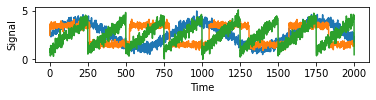

In [19]:
#loading and visualizang dataset
S = mglearn.datasets.make_signals()

plt.figure(figsize=(6,1))
plt.plot(S,'-')
plt.xlabel('Time')
plt.ylabel('Signal')

/home/akado/.local/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:312: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(("The 'init' value, when 'init=None' and "
/home/akado/.local/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1090: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


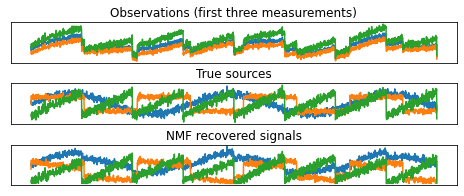

In [24]:
#distorting signals simulating measurement issues
A = np.random.RandomState(0).uniform(size=(100,3))
X = np.dot(S, A.T)

#applying nmf to recover signals
nmf = NMF(n_components=3, random_state=42)
S_ = nmf.fit_transform(X)

#results visualization
models = [X, S, S_]
names = ['Observations (first three measurements)', 'True sources', 'NMF recovered signals']

fig, axes = plt.subplots(3, figsize=(8,3), gridspec_kw={'hspace': 0.5}, subplot_kw={'xticks': (), 'yticks': ()})
for model, name, ax in zip(models, names, axes):
    ax.set_title(name)
    ax.plot(model[:, :3], '-')

^ NMF recovered signals (found components) pretty well